<a href="https://colab.research.google.com/github/NalawadePratima/retail-product-recommender-xai/blob/main/Retail_Product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd

# Load datasets (you should already have these)
orders = pd.read_csv('/content/drive/MyDrive/DATSETS/instacart-market-basket-analysisdata/orders.csv')
order_products = pd.read_csv('/content/drive/MyDrive/DATSETS/instacart-market-basket-analysisdata/all_order_products.csv')
products = pd.read_csv('/content/drive/MyDrive/DATSETS/instacart-market-basket-analysisdata/products.csv')


In [31]:
# Merge products with order_products to get product names
order_products = order_products.merge(products, on='product_id', how='left')

# Merge with orders to get user_id
order_data = order_products.merge(orders[['order_id', 'user_id']], on='order_id', how='left')


In [32]:
order_data.head()


,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,user_id
0,2,33120,1,Organic Egg Whites,86,16,202279
1,2,28985,2,Michigan Organic Kale,83,4,202279
2,2,9327,3,Garlic Powder,104,13,202279
3,2,45918,4,Coconut Butter,19,13,202279
4,2,30035,5,Natural Sweetener,17,13,202279


Step 1.3: Create dictionary: user_id → [product_name1, product_name2, ...]



In [33]:
# Group all prior purchases for each user
user_purchases = order_data.groupby('user_id')['product_name'].apply(list).to_dict()

# Sample
sample_user_id = list(user_purchases.keys())[0]
past_items = user_purchases[sample_user_id][:5]  # Just taking top 5
print(f"Sample User {sample_user_id} Past Items: {past_items}")


Sample User 1 Past Items: ['Soda', 'Original Beef Jerky', 'Pistachios', 'Organic String Cheese', 'Organic Fuji Apples']


## **Finalize Full Modular Pipeline (Recommendation + Explanation)**

Step 1: Define Recommendation + Explanation System

In [34]:
from transformers import pipeline, set_seed
import random

# Initialize explanation model
set_seed(42)
generator = pipeline('text-generation', model='gpt2')

def explain_recommendation(past_items, recommended_item):
    prompt = f"You bought: {', '.join(past_items)}.\nSo, we recommend: {recommended_item}.\nBecause:"
    result = generator(prompt, max_length=50, num_return_sequences=1)
    return result[0]['generated_text']


Device set to use cuda:0


 Step 2: Sample Recommendations (Simulated or from model)

In [35]:
# Pick random user and simulate recommendations
user_id = random.choice(list(user_purchases.keys()))
past_items = user_purchases[user_id][:5]  # last 5 items

# Simulated recommended items (can be from your model output)
recommended_items = ['greek yogurt', 'granola bars', 'blueberries']

# Loop through recommendations and generate explanations
for rec in recommended_items:
    explanation = explain_recommendation(past_items, rec)
    print(f"🛍️ Recommendation for User {user_id}: {rec}")
    print(f"💬 Explanation: {explanation}")
    print("="*70)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🛍️ Recommendation for User 167622: greek yogurt
💬 Explanation: You bought: Soda, Peppermint Patties, Almonds, Soda, Milk Chocolate Kisses.
So, we recommend: greek yogurt.
Because: It's really delicious.
This is my second attempt at some sweet and savory
🛍️ Recommendation for User 167622: granola bars
💬 Explanation: You bought: Soda, Peppermint Patties, Almonds, Soda, Milk Chocolate Kisses.
So, we recommend: granola bars.
Because:
A "candy" bars (those made with the same ingredients as what is
🛍️ Recommendation for User 167622: blueberries
💬 Explanation: You bought: Soda, Peppermint Patties, Almonds, Soda, Milk Chocolate Kisses.
So, we recommend: blueberries.
Because:
So you've already decided to buy this from your regular grocery store!
The good


Sankey Diagram — Show Item Flow (Past ➝ Recommended)
This is great to show "Because the user bought X, we recommend Y".

In [36]:
import plotly.graph_objects as go

# Example data
past_items = ['almond milk', 'granola', 'bananas']
recommended_items = ['greek yogurt', 'blueberries', 'chia seeds']

labels = past_items + recommended_items
sources = [0, 1, 2]      # Indexes of past items
targets = [3, 4, 5]      # Indexes of recommended items
values = [1, 1, 1]       # All equal flow

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(title_text="User Purchase ➝ Recommendation Flow", font_size=12)
fig.show()


Recommendation + Explanation Table
Generate a clean DataFrame with explanation text:\

In [37]:
import pandas as pd

recommendation_data = []

for rec in recommended_items:
    explanation = explain_recommendation(past_items, rec)
    recommendation_data.append({
        'Past Items': ', '.join(past_items),
        'Recommended Item': rec,
        'Explanation': explanation
    })

df = pd.DataFrame(recommendation_data)
df.head()


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


,Past Items,Recommended Item,Explanation
0,"almond milk, granola, bananas",greek yogurt,"You bought: almond milk, granola, bananas.\nSo..."
1,"almond milk, granola, bananas",blueberries,"You bought: almond milk, granola, bananas.\nSo..."
2,"almond milk, granola, bananas",chia seeds,"You bought: almond milk, granola, bananas.\nSo..."


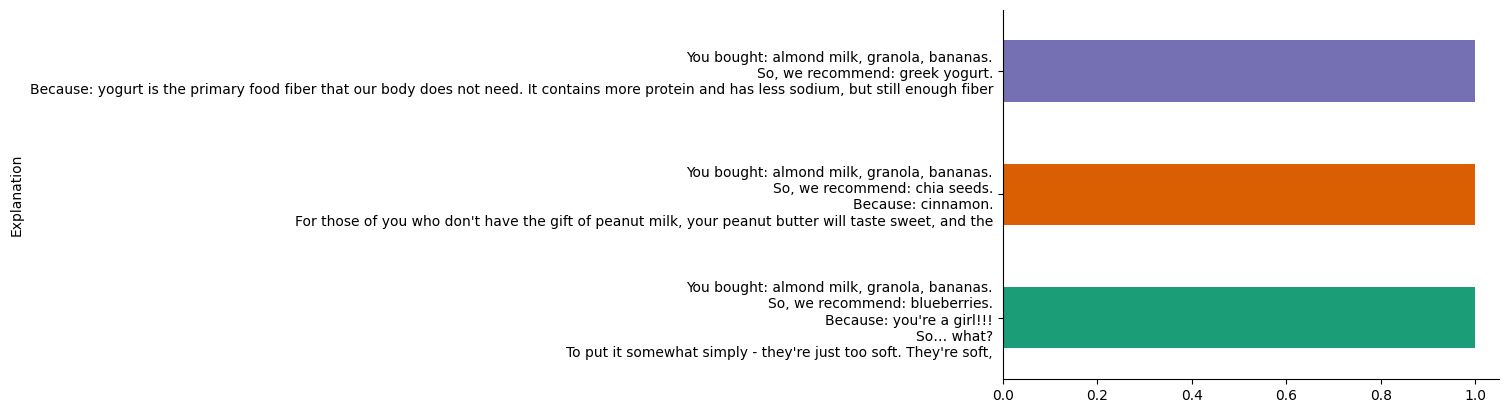

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Explanation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
# prompt: Using dataframe df: Categorical distributions

# Import necessary library
import pandas as pd

# Assuming 'df' is your DataFrame

# Method 1: Using value_counts()
print("Categorical Distribution of 'Recommended Item':\n", df['Recommended Item'].value_counts(normalize=True))
print("\nCategorical Distribution of 'Past Items':\n", df['Past Items'].value_counts(normalize=True))

# Method 2: Using groupby() and size() for a more general approach
print("\nCategorical Distribution of 'Recommended Item' using groupby:\n", df.groupby('Recommended Item').size() / len(df))
print("\nCategorical Distribution of 'Past Items' using groupby:\n", df.groupby('Past Items').size() / len(df))


Categorical Distribution of 'Recommended Item':
 Recommended Item
greek yogurt    0.333333
blueberries     0.333333
chia seeds      0.333333
Name: proportion, dtype: float64

Categorical Distribution of 'Past Items':
 Past Items
almond milk, granola, bananas    1.0
Name: proportion, dtype: float64

Categorical Distribution of 'Recommended Item' using groupby:
 Recommended Item
blueberries     0.333333
chia seeds      0.333333
greek yogurt    0.333333
dtype: float64

Categorical Distribution of 'Past Items' using groupby:
 Past Items
almond milk, granola, bananas    1.0
dtype: float64


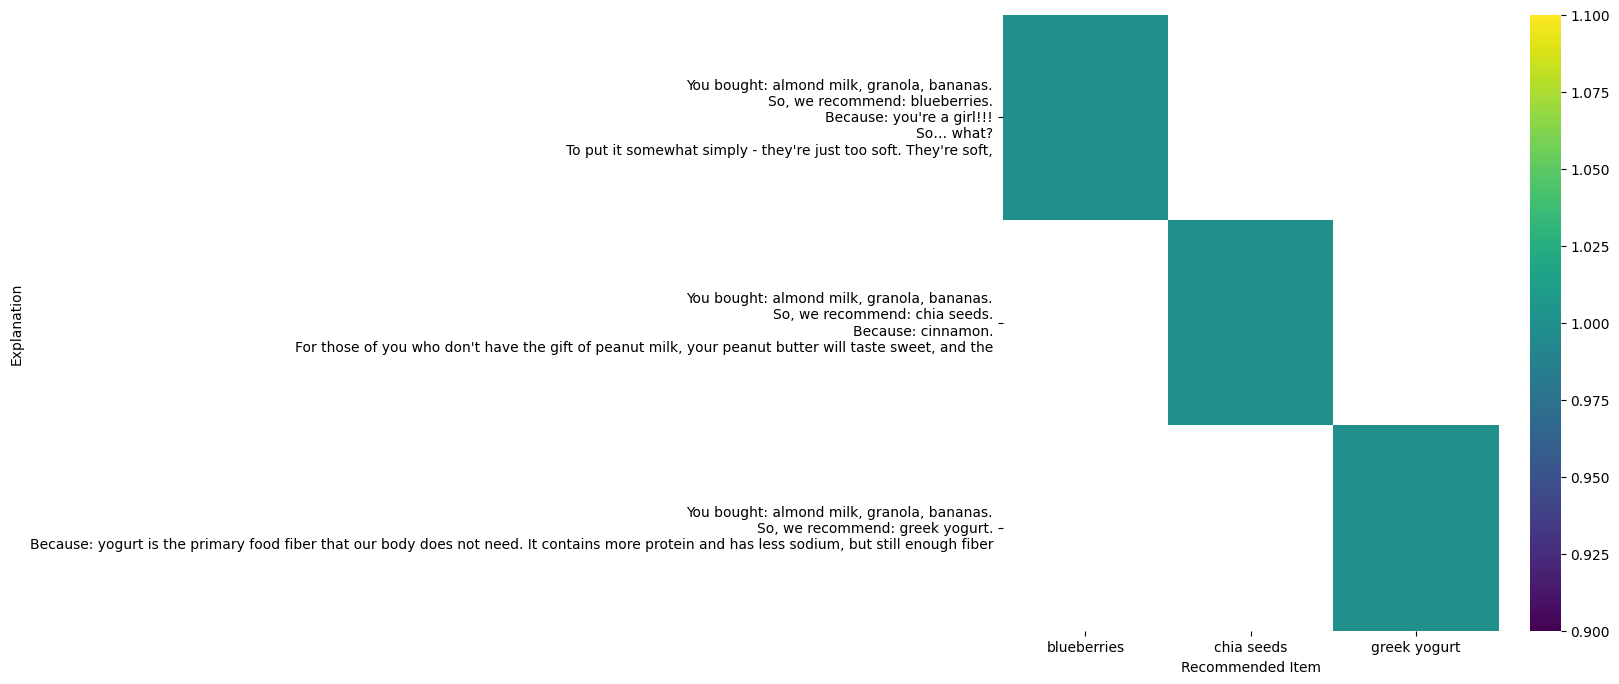

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Explanation'].value_counts()
    for x_label, grp in _df_2.groupby('Recommended Item')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Recommended Item')
_ = plt.ylabel('Explanation')

3. Bar Graph of Most Frequent Products
This helps visualize what a user tends to buy — for building context:

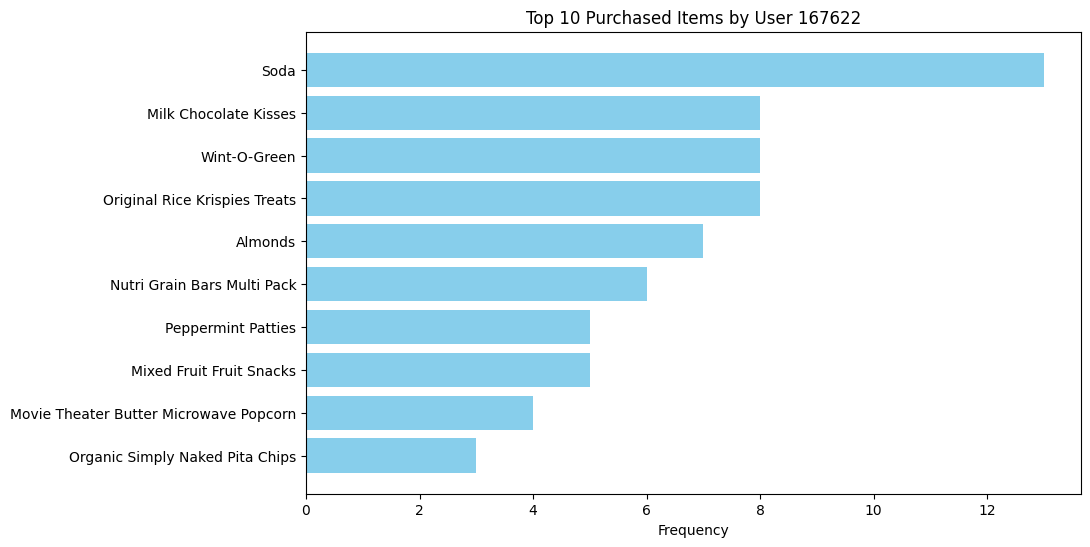

In [41]:
from collections import Counter
import matplotlib.pyplot as plt

# Get frequency of items for one user
user_counter = Counter(user_purchases[user_id])

# Top 10 items
top_items = user_counter.most_common(10)
items, counts = zip(*top_items)

plt.figure(figsize=(10, 6))
plt.barh(items, counts, color='skyblue')
plt.xlabel("Frequency")
plt.title(f"Top 10 Purchased Items by User {user_id}")
plt.gca().invert_yaxis()
plt.show()


\